In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybithumb
import pyupbit
pd.options.display.max_columns = 50
plt.rcParams["figure.figsize"] = (20,12)


In [2]:
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute60", count = 3000)
df

,open,high,low,close,volume,value
2021-10-24 17:00:00,74408000.0,74467000.0,74193000.0,74270000.0,221.300133,1.644693e+10
2021-10-24 18:00:00,74270000.0,74950000.0,74222000.0,74578000.0,267.687801,1.999115e+10
2021-10-24 19:00:00,74578000.0,74836000.0,74500000.0,74795000.0,136.608466,1.019754e+10
2021-10-24 20:00:00,74795000.0,74820000.0,73963000.0,74115000.0,402.420247,2.987831e+10
2021-10-24 21:00:00,74104000.0,74623000.0,73700000.0,74358000.0,506.787534,3.754004e+10
...,...,...,...,...,...,...
2022-02-26 17:00:00,47865000.0,48103000.0,47267000.0,47360000.0,328.199537,1.565377e+10
2022-02-26 18:00:00,47352000.0,47517000.0,47200000.0,47327000.0,184.930834,8.760630e+09
2022-02-26 19:00:00,47323000.0,47732000.0,47322000.0,47658000.0,111.190623,5.288716e+09
2022-02-26 20:00:00,47658000.0,47800000.0,47500000.0,47657000.0,122.854430,5.851499e+09


In [3]:
# 전체 데이터
# df = pybithumb.get_candlestick("BTC")
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute60", count = 5000)
df["time"] = df.index

# 1.VWAP
v = df['volume'].values
tp = (df['low'] + df['close'] + df['high']).div(3).values
df = df.assign(vwap=(tp * v).cumsum() / v.cumsum())
df["diff"] = df["close"] - df["vwap"] # +면 상승세, -면 하락세

# 2.RSI
df["U"] = np.where(df["close"].diff(1) > 0, df["close"].diff(1), 0)  # 전일대비 상승분 가격
df["D"] = np.where(df["close"].diff(1) < 0, df["close"].diff(1) *(-1), 0) # 전일대비 하락분 가격

period = 14  # 하락분의 14일 평균을 구해줍니다.
df["AU"] = df["U"].rolling( window=period, min_periods=period ).mean() # 14일간 전일대비 평균 상승가격 
df["AD"] = df["D"].rolling( window=period, min_periods=period ).mean() # 14일간 전일대비 평균 하락가격

# RSI = AU / (AU + AD) 의 백분율을 RSI 로 계산해줍니다.
RSI = (df["AU"] / (df["AU"] + df["AD"])) * 100
df["rsi"] = RSI

# 3.MACD
def fnMACD(m_Df, m_NumFast=12, m_NumSlow=26, m_NumSignal=9):
    m_Df['EMAFast'] = m_Df['close'].ewm( span = m_NumFast, min_periods = m_NumFast - 1).mean() # 12일의 지수평균이동
    m_Df['EMASlow'] = m_Df['close'].ewm( span = m_NumSlow, min_periods = m_NumSlow - 1).mean() # 26
    m_Df['MACD'] = m_Df['EMAFast'] - m_Df['EMASlow'] 
    m_Df['MACDSignal'] = m_Df['MACD'].ewm( span = m_NumSignal, min_periods = m_NumSignal-1).mean() # 9
    m_Df['MACDDiff'] = m_Df['MACD'] - m_Df['MACDSignal']
    return m_Df
df = fnMACD(df)

# 4.BolingerBand
def fnBolingerBand(m_DF, n=20, k=2):
    m_DF['ma20'] = m_DF['close'].rolling(n).mean()
    m_DF['upper'] = m_DF['close'].rolling(n).mean() + k* m_DF['close'].rolling(n).std()
    m_DF['lower'] = m_DF['close'].rolling(n).mean() - k* m_DF['close'].rolling(n).std()
    return m_DF
df = fnBolingerBand(df)


# 결측치 처리
df = df.fillna(0)
df = df.drop(["time","EMAFast","EMASlow","ma20",], axis= 1 )

df

,open,high,low,close,volume,value,vwap,diff,U,D,AU,AD,rsi,MACD,MACDSignal,MACDDiff,upper,lower
2021-08-02 07:00:00,47813000.0,47884000.0,46685000.0,46970000.0,671.248448,3.161576e+10,4.717967e+07,-2.096667e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-08-02 08:00:00,46970000.0,47042000.0,46003000.0,46274000.0,960.155344,4.460672e+10,4.674414e+07,-4.701430e+05,0.0,696000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-08-02 09:00:00,46263000.0,46599000.0,45587000.0,45700000.0,940.454569,4.333216e+10,4.645814e+07,-7.581358e+05,0.0,574000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-08-02 10:00:00,45711000.0,46203000.0,45438000.0,46012000.0,601.084181,2.757832e+10,4.634943e+07,-3.374343e+05,312000.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
2021-08-02 11:00:00,46021000.0,46423000.0,45890000.0,46312000.0,305.367053,1.408255e+10,4.633705e+07,-2.504682e+04,300000.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 17:00:00,47865000.0,48103000.0,47267000.0,47360000.0,328.199537,1.565377e+10,6.001629e+07,-1.265629e+07,0.0,504000.0,131428.571429,126500.000000,50.955414,229069.289332,358330.965071,-129261.675739,4.849660e+07,4.716240e+07
2022-02-26 18:00:00,47352000.0,47517000.0,47200000.0,47327000.0,184.930834,8.760630e+09,6.001486e+07,-1.268786e+07,0.0,33000.0,131428.571429,124142.857143,51.425377,177778.467580,322220.465573,-144441.997993,4.848214e+07,4.710026e+07
2022-02-26 19:00:00,47323000.0,47732000.0,47322000.0,47658000.0,111.190623,5.288716e+09,6.001401e+07,-1.235601e+07,331000.0,0.0,117142.857143,124142.857143,48.549438,161971.943784,290170.761215,-128198.817431,4.848108e+07,4.709562e+07
2022-02-26 20:00:00,47658000.0,47800000.0,47500000.0,47657000.0,122.854430,5.851499e+09,6.001309e+07,-1.235609e+07,0.0,1000.0,117142.857143,115000.000000,50.461538,147662.308973,261669.070767,-114006.761794,4.843991e+07,4.708919e+07


In [4]:
# ARIMA 모델

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

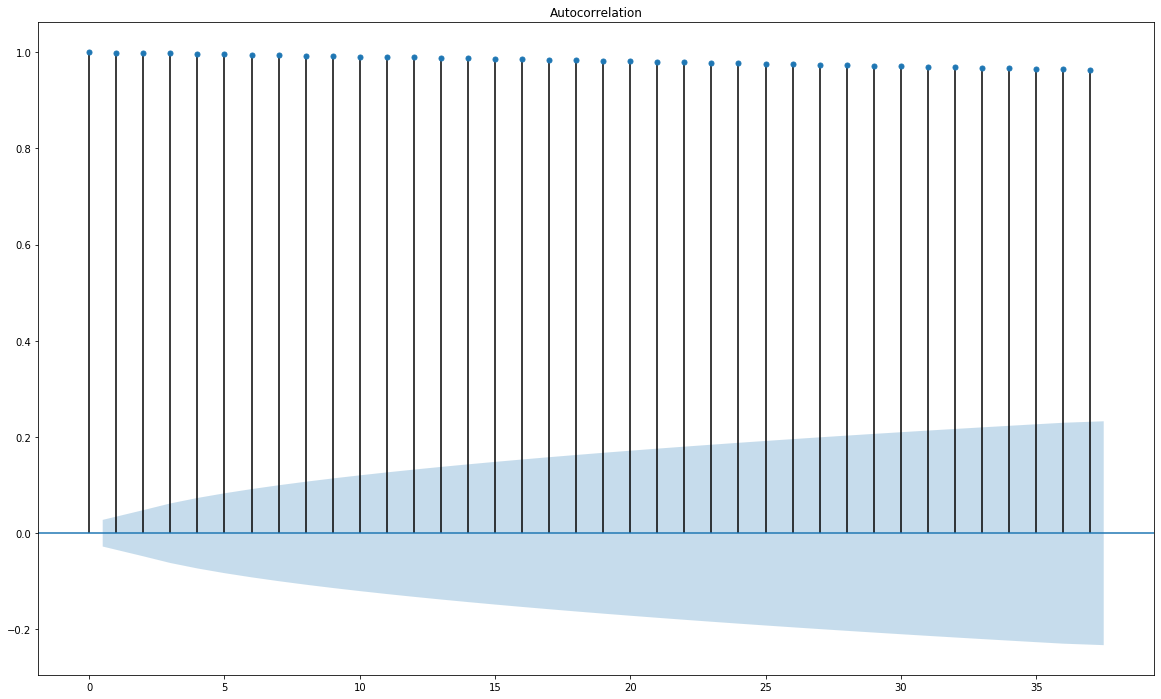

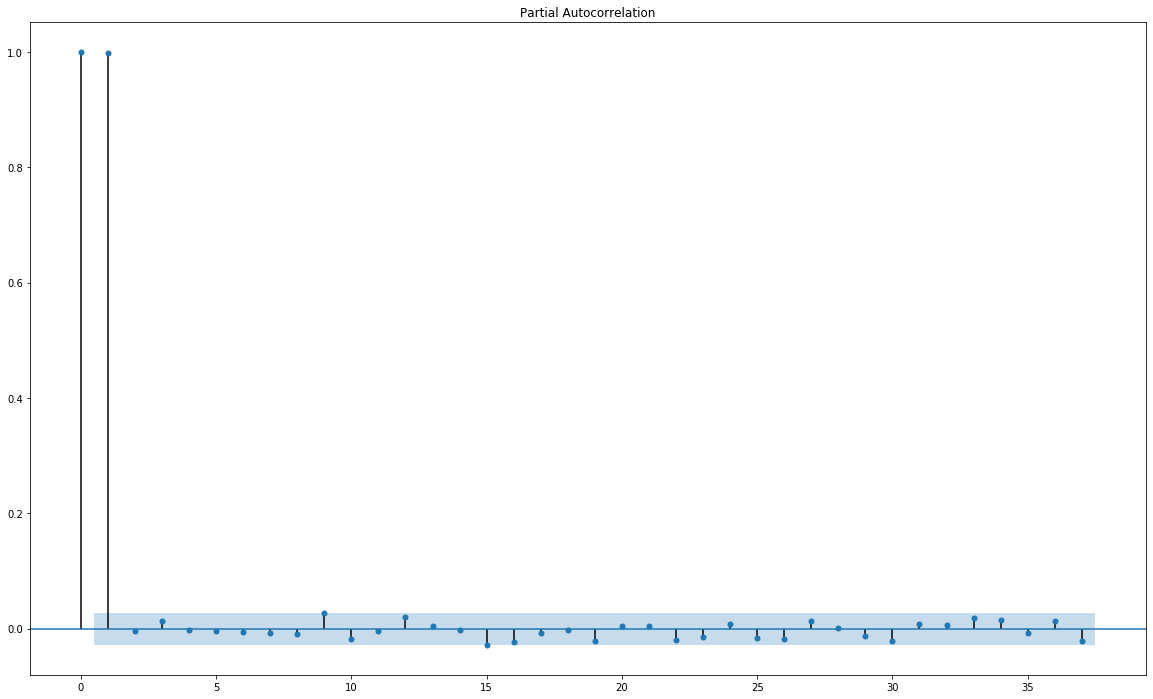

In [5]:
#ARIMA 의 order 파라미터 p,d,q의 최적 조합 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF : 관측치들 사이 관련성을 측정
plot_acf(df["close"])
# PACF : K 이외의 모든 다른 시점 관측치의 영향력을 배제하고 일정 시점의 주 관측치의 관련성을 측정
plot_pacf(df["close"])
plt.show()

# 시계열 데이터가 AR의 측성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소합니다. 
# MA의 특성을 띄는 경우 AR과 반대로 ACF 값은 급격히 감소, PACF는 천천히 감소하는 경향을 보입니다.

# 결과
# ACF 결과를 살펴보면, 자기상관은 항상 양의 값을 가지고 있습니다. p의 값은 크게 조절할 필요가 없다고 판단됩니다. 
# PACF 결과는 처음 시차를 제외하고 급격히 감소합니다. 종합적으로 고려하면 p=0, q=1로 파라미터를 조정하는 것이 적절하다고 판단됩니다.
# 참고로, p, d, q의 파라미터는 일반적인 가이드라인이 존재합니다. 
# 보통 p와 q의 합이 2미만이거나, p와 q의 곱이 0을 포합한 짝수가 좋은 조합이라고 알려져 있습니다.

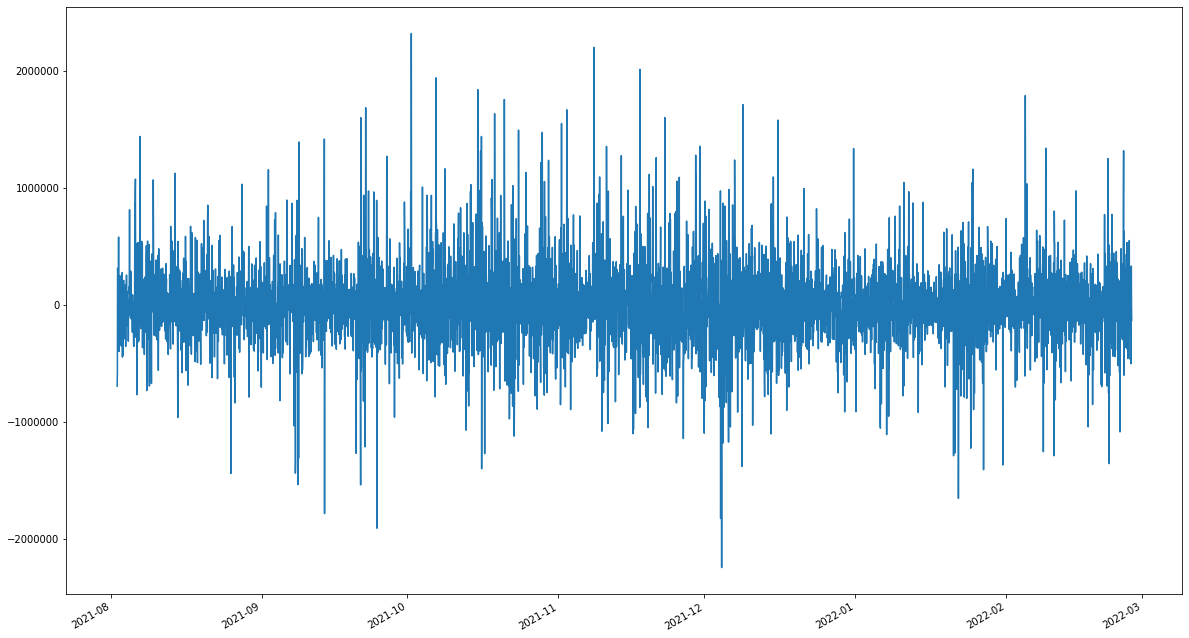

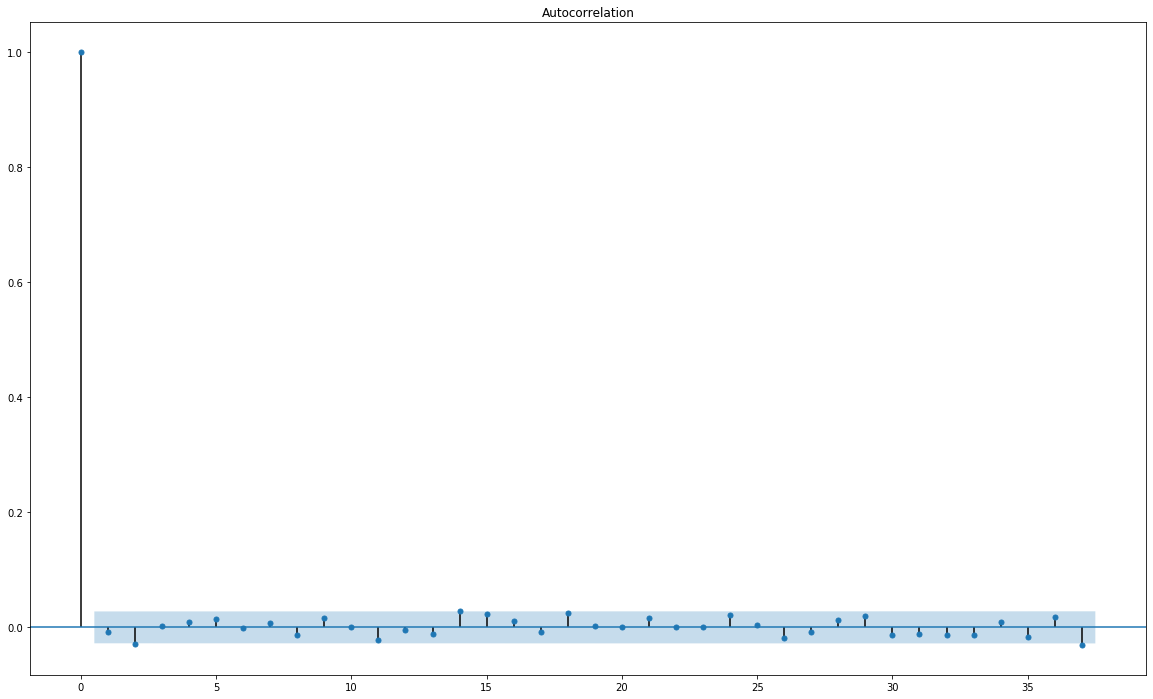

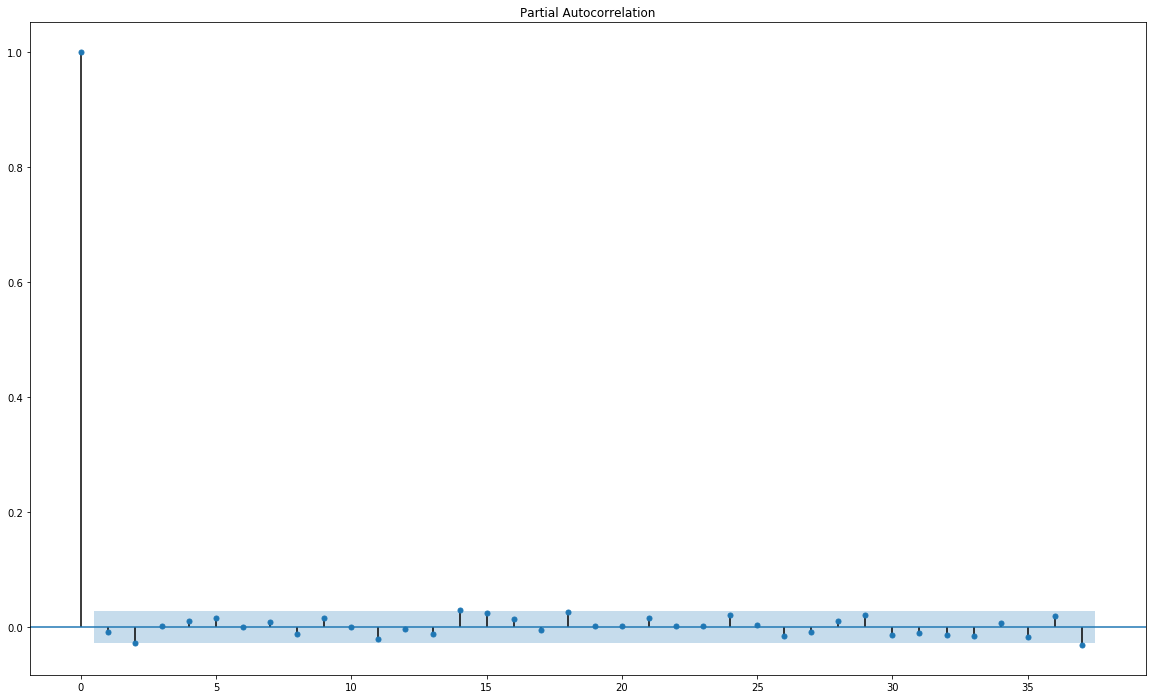

In [6]:
# 적절 차분 차수 d 계산 
tmp=df["close"].diff(periods=1).iloc[1:]
tmp.plot()
plot_acf(tmp)
plot_pacf(tmp)
plt.show()

# 차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 
# 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 수행합니다. 또한 ARIMA의 경향성을 반영한 값입니다. 
# 위 결과를 바탕으로 최종 파라미터는 (0,2,1)로 결정하였습니다.

In [46]:
# ARIMA로 학습

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from pmdarima.arima import auto_arima
import pmdarima as pm

model = ARIMA(df["diff"].values, order=(0,2,1)) #파라미터 설정
model_fit = model.fit(trend='nc', full_output=True, disp=True)
print(model_fit.summary())

# ar = pm.auto_arima(df["close"], seasonal=False, m=24)
# forecasts = ar.predict(24)  # predict N steps into the future
# forecasts


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 4998
Model:                 ARIMA(0, 2, 1)   Log Likelihood              -70908.431
Method:                       css-mle   S.D. of innovations         350706.135
Date:                Sat, 26 Feb 2022   AIC                         141820.862
Time:                        21:45:01   BIC                         141833.896
Sample:                             2   HQIC                        141825.430
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D2.y    -0.9996      0.001  -1015.455      0.000      -1.002      -0.998
                                    Roots                                    
                  Real          Imaginary           M

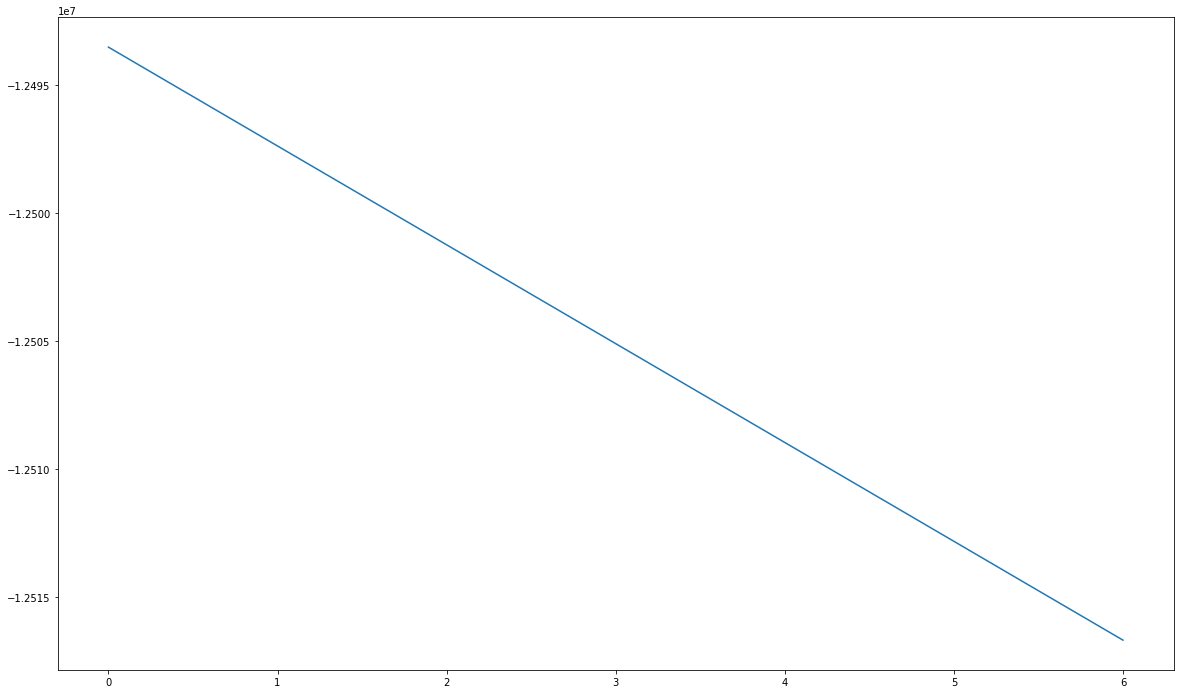

In [47]:
list(pred)
plt.plot(pred)

In [48]:
# ARIMA 모델의 t-test 값은 p-value로 상수항을 제외한 모든 계수의 p-value가 0.05이하인 경우 유의미
# ma.L1.D2.y 변수값의 p-value는 0.000으로 적정한 파라미터 값을 대입했다고 판단

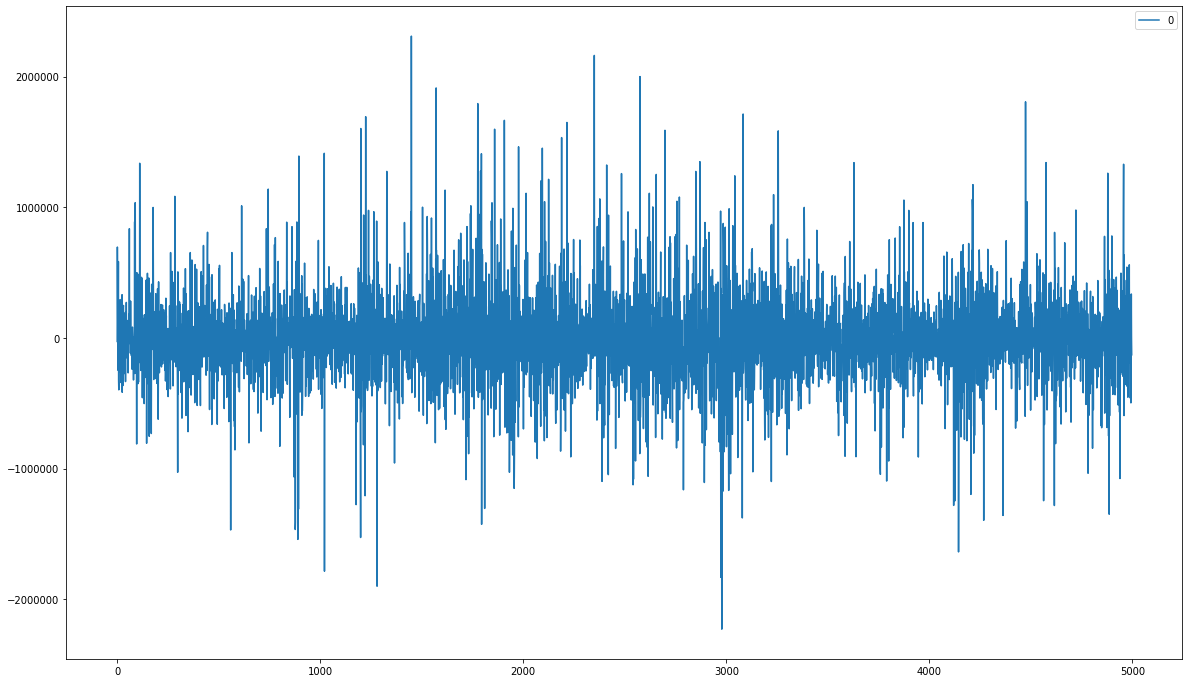

In [49]:
# 잔차의 변동 시각화
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# 폭이 일정해야 좋음 -> 불규칙한 형태, 불안정한 잔차임

In [50]:
# 예측결과

pred_model = model_fit.forecast(steps=7) # 일주일 예측
pred = list(map(int,pred_model[0]))
pred[-1]

-12516686

In [51]:
pyupbit.get_current_price()

47557000.0

In [52]:
pred_lower = []
pred_upper = []

for lower_upper in pred_model[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_lower.append(lower)
    pred_upper.append(upper)


In [53]:
# 시각화
plt.plot(pred, color="blue") # 예측 가격
plt.plot(pred_upper, color = "purple") # 예측 최고가격
plt.plot(pred_lower, color = "green") # 예측 최저가격
plt.plot(df["close"][-7:], color = "red") # 실제가격

ValueError: view limit minimum -36910.64375 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

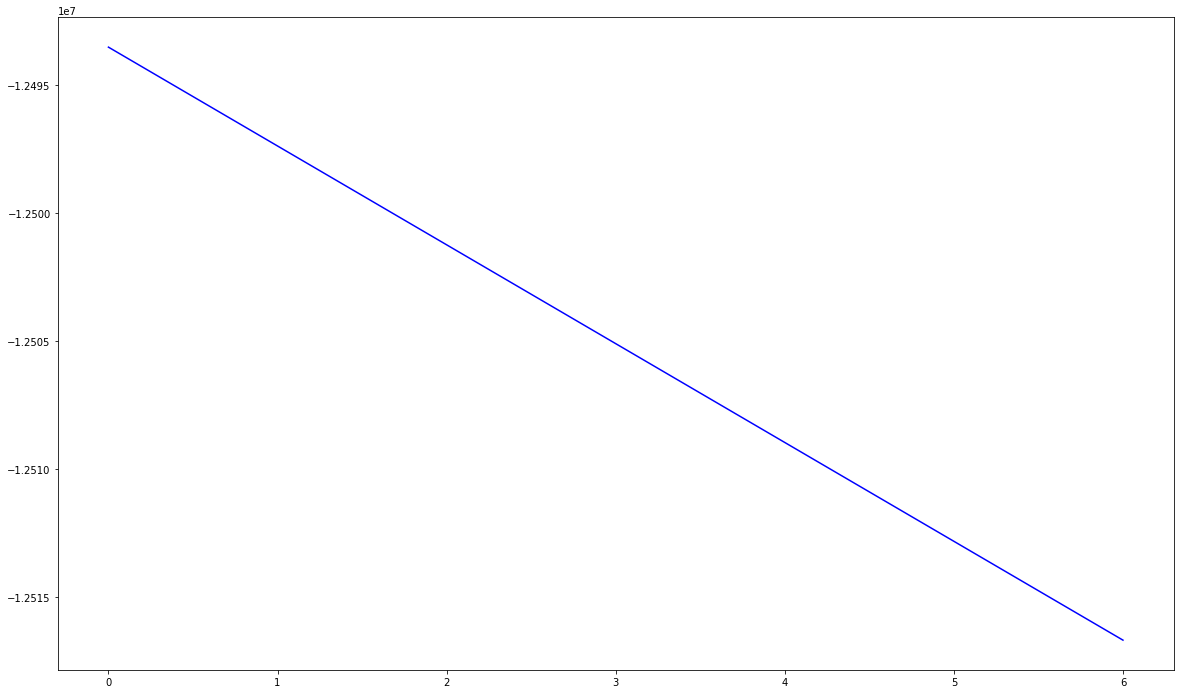

In [54]:
plt.plot(pred, color="blue") # 예측 가격
# 추이는 예측 성공

In [56]:
from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(pred, df["diff"][-7:]))
print(rmse)

187884.14949824897


In [ ]:
# 불규칙한 시계열 예측의 경우, 먼 미래를 예측하는 것은 큰 의미가 없다. 
# 따라서 앞으로 N일 동안 어느 정도로 상승(하락)할 것인지 대략적인 Trend 예측만을 수행하는 것이 일반적